In [1]:
import pandas as pd
import seaborn as sns
import pandas as pd
import warnings
from matplotlib.lines import Line2D
import os
import scanpy as sc
import numpy as np
import torch
import random

import sys
sys.path.append(os.path.abspath("../"))
from metrics import spearman_score, pearson_score, root_mean_square_error, mean_square_error
from utils import random_splits

from scipy.stats import norm, rankdata
from sklearn.metrics import mutual_info_score
from sklearn.preprocessing import KBinsDiscretizer

import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['pdf.fonttype'] = 42  # Ensures text is stored as editable Type 1 fonts
plt.rcParams['ps.fonttype'] = 42   # For EPS compatibility

warnings.simplefilter(action="ignore", category=Warning)

def fix_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

fix_seed(42)

dir_path1 = '/ewsc/wuqitian/hest_data_xenium_protein_preprocess'
meta_info1 = pd.read_csv("../../data/meta_info_xenium.csv")

dir_path2 = '/ewsc/wuqitian/lung_preprocess'
meta_info2 = pd.read_csv("../../data/meta_info_lung.csv")

result_path = '/ewsc/wuqitian/analysis_pred_data/gene_expression_prediction/'

cell_lineage = ['Epithelial', 'Immune', 'Endothelial', 'Mesenchymal']
cl_map = {c: i for i, c in enumerate(cell_lineage)}
cl_map_inv = {i: c for i, c in enumerate(cell_lineage)}
cell_type = ['RASC', 'Secretory', 'Multiciliated', 'PNEC', 'Basal', 'Goblet', 'Proliferating Airway', 'AT2', 'Transitional AT2', 'AT1', 
             'KRT5-/KRT17+', 'Proliferating AT2', 'Langerhans cells', 'NK/NKT', 'Tregs', 'CD4+ T-cells', 'CD8+ T-cells', 
             'Proliferating T-cells', 'B cells', 'Plasma', 'pDCs', 'Proliferating NK/NKT', 'Proliferating B cells', 'cDCs', 'Mast', 
             'Interstitial Macrophages', 'Alveolar Macrophages', 'SPP1+ Macrophages', 'Neutrophils', 'Proliferating Myeloid', 
             'Migratory DCs', 'Macrophages - IFN-activated', 'Monocytes/MDMs', 'Basophils', 'Venous', 'Capillary', 'Lymphatic', 
             'Arteriole', 'SMCs/Pericytes', 'Alveolar FBs', 'Proliferating FBs', 'Inflammatory FBs', 'Activated Fibrotic FBs', 
             'Myofibroblasts', 'Subpleural FBs', 'Adventitial FBs', 'Mesothelial']
ct_map = {c: i for i, c in enumerate(cell_type)}
ct_map_inv = {i: c for i, c in enumerate(cell_type)}

def pearson_score(y_true, y_pred, rank_axis='by_gene'):

    axis = 1 if rank_axis == 'by_gene' else 0

    matrix1 = y_true - np.mean(y_true, axis=axis, keepdims=True)
    matrix2 = y_pred - np.mean(y_pred, axis=axis, keepdims=True)

    covariance = np.sum(matrix1 * matrix2, axis=axis, keepdims=True)

    std1 = np.sqrt(np.sum(matrix1 ** 2, axis=axis, keepdims=True))
    std2 = np.sqrt(np.sum(matrix2 ** 2, axis=axis, keepdims=True))

    std_prod = std1 * std2

    if rank_axis == 'by_gene':
        nonzero = std_prod.nonzero()[0]
        corrs = covariance[nonzero] / std_prod[nonzero]
    else:
        nonzero = std_prod.nonzero()[1]
        corrs = covariance[:, nonzero] / std_prod[:, nonzero]

    return np.mean(corrs)

def spearman_score(y_true, y_pred, rank_axis='by_gene'):

    axis = 1 if rank_axis == 'by_gene' else 0

    ranked_matrix1 = np.apply_along_axis(rankdata, axis=axis, arr=y_true)
    ranked_matrix2 = np.apply_along_axis(rankdata, axis=axis, arr=y_pred)

    ranked_matrix1 -= np.mean(ranked_matrix1, axis=axis, keepdims=True)
    ranked_matrix2 -= np.mean(ranked_matrix2, axis=axis, keepdims=True)

    covariance = np.sum(ranked_matrix1 * ranked_matrix2, axis=axis, keepdims=True)

    std1 = np.sqrt(np.sum(ranked_matrix1 ** 2, axis=axis, keepdims=True))
    std2 = np.sqrt(np.sum(ranked_matrix2 ** 2, axis=axis, keepdims=True))

    std_prod = std1 * std2

    if rank_axis == 'by_gene':
        nonzero = std_prod.nonzero()[0]
        corrs = covariance[nonzero] / std_prod[nonzero]
    else:
        nonzero = std_prod.nonzero()[1]
        corrs = covariance[:, nonzero] / std_prod[:, nonzero]

    return np.mean(corrs)

def mutual_information_kl(X, Y, bins=50):
    min_val, max_val = np.min(X), np.max(X)
    bin_edges = np.linspace(min_val, max_val, bins + 1)

    # Compute marginal probabilities
    p_x, _ = np.histogram(X, bins=bin_edges, density=True)
    p_x /= np.sum(p_x)

    p_y, _ = np.histogram(Y, bins=bin_edges, density=True)
    p_y /= np.sum(p_y)

    # Compute joint probability
    p_xy, _, _ = np.histogram2d(X, Y, bins=[bin_edges, bin_edges], density=True)
    p_xy /= np.sum(p_xy)

    # Compute MI using KL divergence
    p_xp_y = np.outer(p_x, p_y)
    p_xp_y = np.clip(p_xp_y, 1e-10, None)  # Avoid log(0)
    p_xy = np.clip(p_xy, 1e-10, None)

    mi = np.sum(p_xy * np.log(p_xy / p_xp_y))
    return mi

def conditional_mutual_information(X, Z, Y, bins=50):
    mi_x_y = np.sum([mutual_information_kl(X, Y[:, i], bins) for i in range(Y.shape[1])])  # MI(X; Y)
    mi_x_yz = np.sum([mutual_information_kl(X, Y[:, i], bins) for i in range(Y.shape[1])]) + mutual_information_kl(X, Z, bins)  # MI(X; Y, Z)

    return mi_x_yz - mi_x_y

def transformation(x, norm):
    x = x / norm * 1e4
    x = np.log1p(x)
    return x

def normalize(x):
    return (x - x.min()) / (x.max() - x.min() + 1e-5)

def compute_conditional_entropy(y, X):
    cond_ents = [mutual_information_kl(y, y) - mutual_information_kl(y, X[:, i]) for i in range(X.shape[1])]
    return cond_ents

/local_home/wuqitian/anaconda3/envs/bio/lib/python3.12/site-packages/torch_geometric/typing.py:68: UserWarning: An issue occurred while importing 'pyg-lib'. Disabling its usage. Stacktrace: /lib64/libm.so.6: version `GLIBC_2.29' not found (required by /local_home/wuqitian/anaconda3/envs/bio/lib/python3.12/site-packages/libpyg.so)
  warnings.warn(f"An issue occurred while importing 'pyg-lib'. "
/local_home/wuqitian/anaconda3/envs/bio/lib/python3.12/site-packages/torch_geometric/typing.py:124: UserWarning: An issue occurred while importing 'torch-sparse'. Disabling its usage. Stacktrace: /lib64/libm.so.6: version `GLIBC_2.29' not found (required by /local_home/wuqitian/anaconda3/envs/bio/lib/python3.12/site-packages/libpyg.so)
  warnings.warn(f"An issue occurred while importing 'torch-sparse'. "


['ABCC11' 'ACKR1' 'ADGRL4' 'ADIPOQ' 'AGER' 'AHSP' 'ALAS2' 'ANGPT2'
 'APOBEC3A' 'AQP2' 'ASCL3' 'BAMBI' 'BMX' 'C5orf46' 'CA4' 'CCDC39' 'CCDC78'
 'CD1E' 'CD274' 'CD300E' 'CD68' 'CD70' 'CDH16' 'CENPF' 'CHGA' 'CLCA1'
 'CLEC10A' 'CLIC5' 'CPA3' 'CSF3' 'CTSG' 'CXCL10' 'CYP2F1' 'DMBT1' 'DNAAF1'
 'ELF5' 'ESR1' 'FCER1A' 'FCN1' 'FOXA1' 'FOXI1' 'FOXJ1' 'FOXP3' 'GCG'
 'GHRL' 'GKN2' 'GNLY' 'GYPB' 'GZMB' 'HAVCR2' 'HES4' 'HIGD1B' 'IL1RL1'
 'INS' 'KCNK3' 'KIT' 'KRT20' 'LAG3' 'LAMP3' 'LGI4' 'LILRA4' 'LILRA5'
 'LILRB2' 'LILRB4' 'MCEMP1' 'MLANA' 'MS4A2' 'NAT8' 'OPRPN' 'PCOLCE' 'PGR'
 'PLA2G7' 'PLAC9' 'PNP' 'PVALB' 'RERGL' 'RETN' 'RGS16' 'SELE' 'SLC18A2'
 'SLC22A8' 'SLC4A1' 'SNAI1' 'SNCA' 'SNTN' 'SOX17' 'SOX2' 'SPDEF' 'SPI1'
 'SRPX' 'SST' 'STC1' 'TCF15' 'TFF2' 'TM4SF18' 'TMEM52B' 'TREM2' 'UBE2C'
 'UMOD' 'VSIG4']
0.39602083 0.4625524 0.47179666 0.5437461


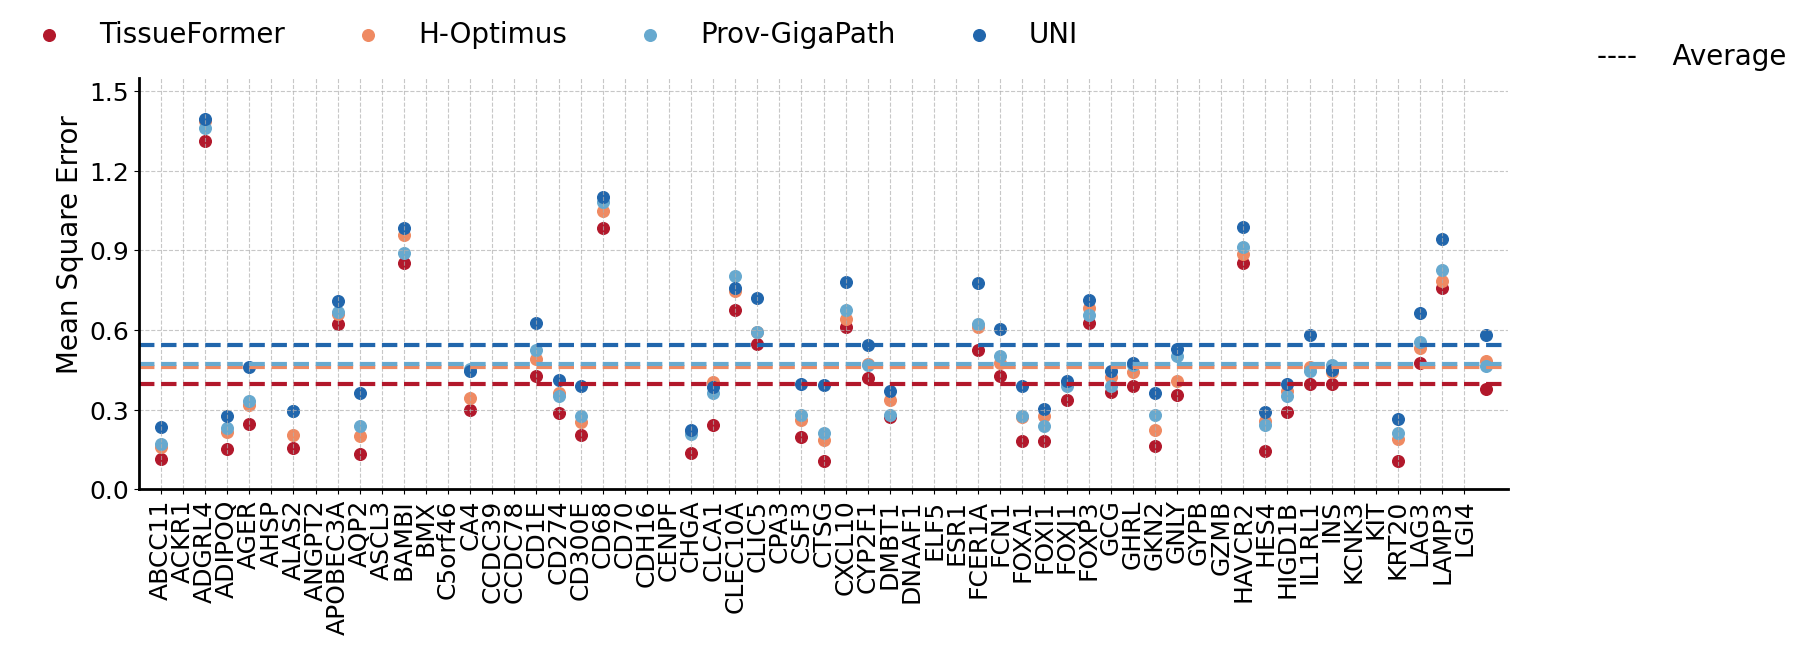

In [17]:
from scipy.cluster.hierarchy import linkage, dendrogram, leaves_list

genes, labels = [], []
scores_ours, scores_hoptimus, scores_gigapath, scores_uni, scores_pca, scores_visium = [], [], [], [], [], []

samples = ['TENX126', 'TENX123', 'TENX124', 'TENX121', 'TENX119', 'TENX118']
organs = ['Pancreas', 'Skin', 'Lymphoid', 'Liver', 'Heart', 'Lung']

marker_genes = ['SNAI1', 'PVALB', 'LILRA4', 'FCN1', 'CYP2F1', 'CHGA', 'CD274', 'CD68', 'MCEMP1', 'CA4', 
                'UBE2C', 'KRT20', 'UMOD', 'ALAS2', 'ADIPOQ', 'FOXA1', 'APOBEC3A', 'GHRL', 'GNLY', 'INS', 
                'SELE', 'HAVCR2', 'NAT8', 'GCG', 'VSIG4', 'FOXP3', 'CXCL10', 'BAMBI', 'ABCC11', 'AQP2', 
                'CTSG', 'HES4', 'SST', 'OPRPN', 'SLC18A2', 'ADGRL4', 'SLC4A1', 'CD300E', 'MLANA', 'CSF3', 
                'CLIC5', 'SOX17', 'DMBT1', 'GKN2', 'TMEM52B', 'HIGD1B', 'SOX2', 'LAMP3', 'CD1E', 'LAG3', 
                'FOXJ1', 'FCER1A', 'PLAC9', 'RETN', 'CLEC10A', 'IL1RL1', 'FOXI1', 'CLCA1', 'AGER', 'TREM2', 
                'CENPF', 'AHSP', 'LILRA5', 'SPDEF', 'RGS16', 'LILRB4', 'DNAAF1', 'PLA2G7', 'ASCL3', 'TM4SF18', 
                'KIT', 'SLC22A8', 'LILRB2', 'PGR', 'MS4A2', 'ACKR1', 'ELF5', 'ANGPT2', 'PNP', 'GZMB', 'ESR1', 
                'BMX', 'CCDC39', 'LGI4', 'SNCA', 'CDH16', 'C5orf46', 'TFF2', 'RERGL', 'TCF15', 'KCNK3', 'STC1', 
                'CPA3', 'SNTN', 'PCOLCE', 'CCDC78', 'GYPB', 'CD70', 'SPI1', 'SRPX'] 

for s, sample in enumerate(samples):
    file_path = os.path.join(dir_path1, sample) + '.h5ad'
    adata = sc.read(file_path)
    gene_filter_mask = adata.var['gene_filter_mask']
    adata = adata[:, gene_filter_mask]
    
    file_path = result_path + f'{sample}_true.npy'
    y_true = np.load(file_path)
    file_path = result_path + f'{sample}_ours.npy'
    y_pred = np.load(file_path)
    file_path = result_path + f'{sample}_hoptimus-MLP.npy'
    y_pred_hoptimus = np.load(file_path)
    file_path = result_path + f'{sample}_gigapath-MLP.npy'
    y_pred_gigapath = np.load(file_path)
    file_path = result_path + f'{sample}_uni-MLP.npy'
    y_pred_uni = np.load(file_path)

    for marker_gene in marker_genes:
        gene_mask = adata.var['gene_names']==marker_gene
        if gene_mask.sum() < 1:
            continue
        y_true_m, y_pred_m = y_true[:, gene_mask].reshape(-1, 1), y_pred[:, gene_mask].reshape(-1, 1)
        y_pred_hoptimus_m, y_pred_gigapath_m, y_pred_uni_m = \
            y_pred_hoptimus[:, gene_mask].reshape(-1, 1), y_pred_gigapath[:, gene_mask].reshape(-1, 1), y_pred_uni[:, gene_mask].reshape(-1, 1)

        scores_ours += [((y_true_m - y_pred_m)**2).mean()]
        scores_hoptimus += [((y_true_m - y_pred_hoptimus_m)**2).mean()]
        scores_gigapath += [((y_true_m - y_pred_gigapath_m)**2).mean()]
        scores_uni += [((y_true_m - y_pred_uni_m)**2).mean()]
        genes += [marker_gene]
        labels += [organs[s]]

marker_genes_sorted = np.sort(np.array(marker_genes))
xs = {g:i for i, g in enumerate(marker_genes_sorted)}
print(marker_genes_sorted)

fig, ax = plt.subplots(figsize=(18, 7))

model_color = ['#b2182b', '#ef8a62', '#67a9cf', '#2166ac', '#2166ac']
model_names = ['TissueFormer', 'H-Optimus', 'Prov-GigaPath', 'UNI', 'PCA']

genes = np.array(genes)
labels = np.array(labels)
scores_ours, scores_hoptimus, scores_gigapath, scores_uni = \
    np.array(scores_ours), np.array(scores_hoptimus), np.array(scores_gigapath), np.array(scores_uni)

for i, g in enumerate(marker_genes[:60]):
    mask_g = genes==g
    avg_score_ours_g = scores_ours[mask_g].mean()
    avg_score_hoptimus_g = scores_hoptimus[mask_g].mean()
    avg_score_gigapath_g = scores_gigapath[mask_g].mean()
    avg_score_uni_g = scores_uni[mask_g].mean()

    h1 = ax.scatter(xs[g], avg_score_ours_g, color=model_color[0], s=70, alpha=1.0, marker='o', label=model_names[0])
    h2 = ax.scatter(xs[g], avg_score_hoptimus_g, color=model_color[1], s=70, alpha=1.0, marker='o', label=model_names[1])
    h3 = ax.scatter(xs[g], avg_score_gigapath_g, color=model_color[2], s=70, alpha=1.0, marker='o', label=model_names[2])
    h4 = ax.scatter(xs[g], avg_score_uni_g, color=model_color[3], s=70, alpha=1.0, marker='o', label=model_names[3])
    
    if i==0:
        handles = [h1, h2, h3, h4]

avg_score_ours = scores_ours.mean()
ax.hlines(y=avg_score_ours, xmin=-1, xmax=61, colors=model_color[0], linestyles='--', linewidth=3.0)
avg_score_hoptimus = scores_hoptimus.mean()
ax.hlines(y=avg_score_hoptimus, xmin=-1, xmax=61, colors=model_color[1], linestyles='--', linewidth=3.0)
avg_score_gigapath = scores_gigapath.mean()
ax.hlines(y=avg_score_gigapath, xmin=-1, xmax=61, colors=model_color[2], linestyles='--', linewidth=3.0)
avg_score_uni = scores_uni.mean()
ax.hlines(y=avg_score_uni, xmin=-1, xmax=61, colors=model_color[3], linestyles='--', linewidth=3.0)

print(avg_score_ours, avg_score_hoptimus, avg_score_gigapath, avg_score_uni)

ax.set_xlabel(" ", fontsize=10)
ax.set_ylabel("         Mean Square Error", fontsize=20)
ax.set_xlim(-1, 61)
ax.set_xticks(ticks=range(len(marker_genes_sorted[:60])), labels=marker_genes_sorted[:60], rotation=90)
ax.set_ylim(0, 1.55)
ax.set_yticks([0., 0.3, 0.6, 0.9, 1.2, 1.5]) 

ax.tick_params(axis='x', labelsize=18)
ax.tick_params(axis='y', labelsize=18)
ax.grid(axis='x', linestyle='--', alpha=0.7)
ax.grid(axis='y', linestyle='--', alpha=0.7)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)

ax.legend(handles, model_names, loc='upper center', fontsize=20, ncols=5, bbox_to_anchor=(0.3, 1.2), frameon=False)
ax.text(65, 1.6, '----    Average', verticalalignment='baseline', fontsize=20)

plt.tight_layout()
plt.savefig('../../figure/pred_xenium_genewise_sample.pdf')
plt.show()


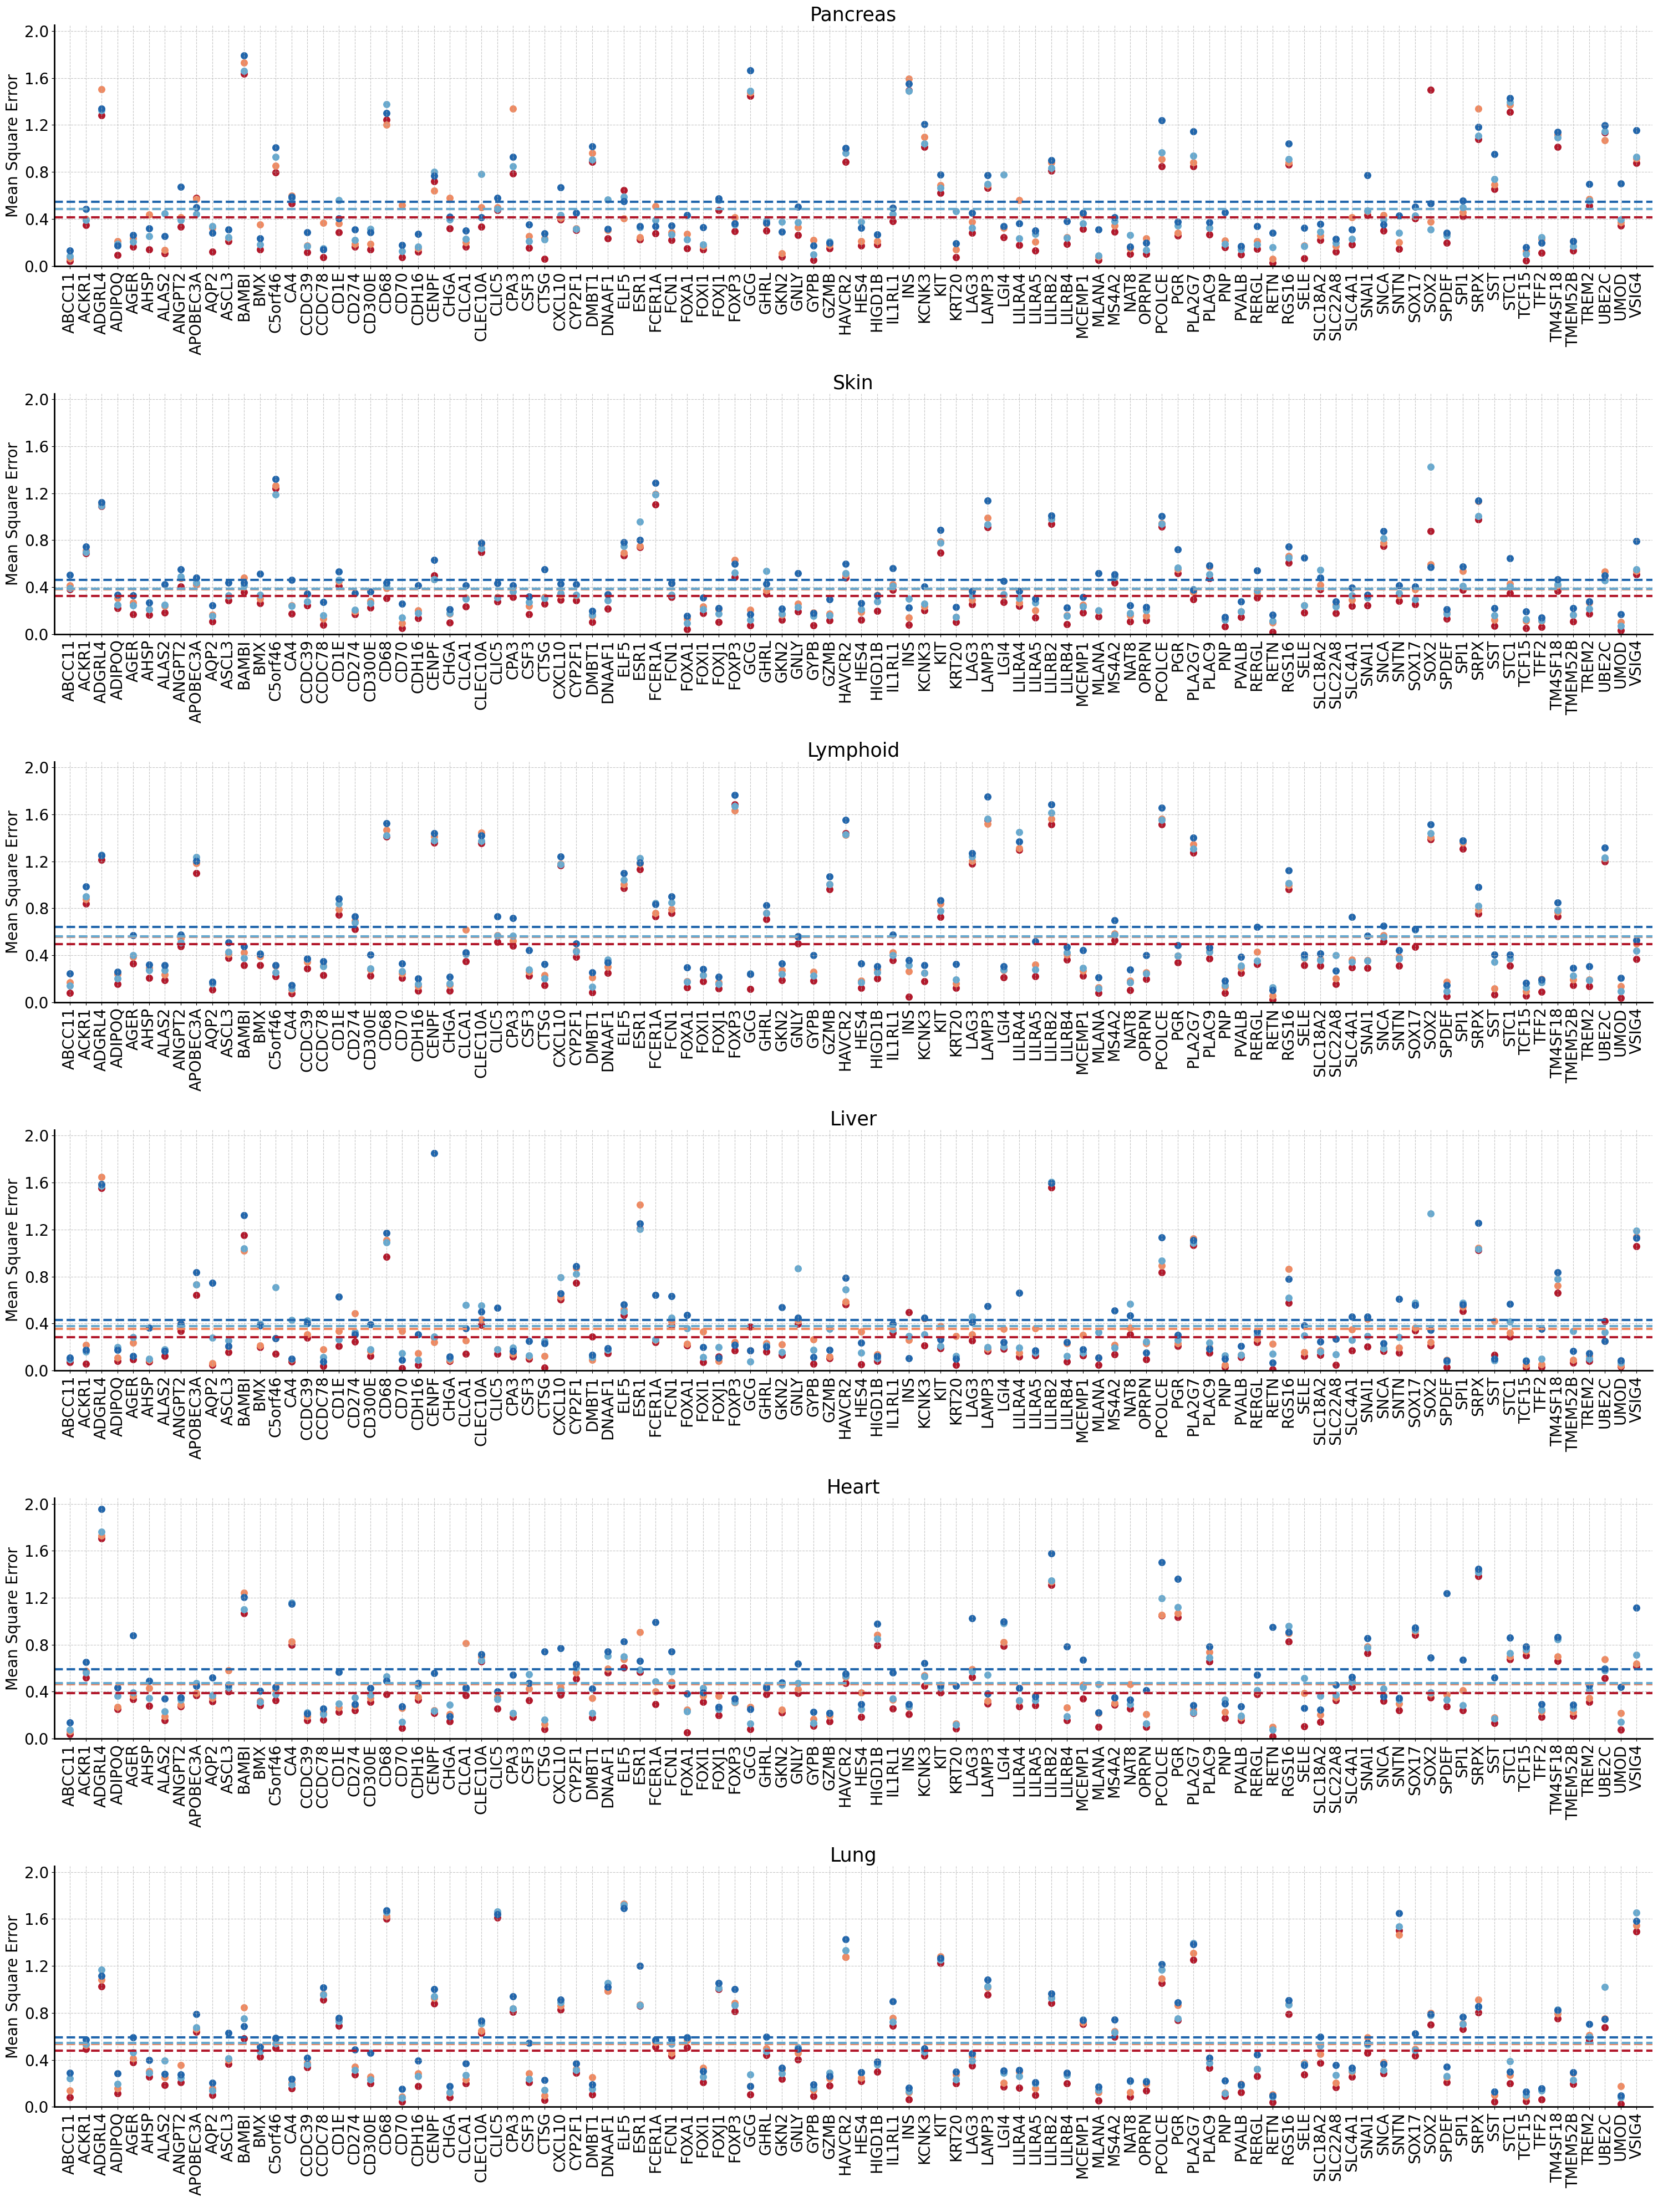

In [18]:
fig, axes = plt.subplots(6, 1, figsize=(30, 40))
axes = axes.flatten()

for k, o in enumerate(organs):
    ax = axes[k]
    mask_o = labels==o
    scores_ours_o = scores_ours[mask_o]
    scores_hoptimus_o = scores_hoptimus[mask_o]
    scores_gigapath_o = scores_gigapath[mask_o]
    scores_uni_o = scores_uni[mask_o]
    for i, g in enumerate(marker_genes):
        mask_g = genes[mask_o]==g
        avg_score_ours_g = scores_ours_o[mask_g].mean()
        avg_score_hoptimus_g = scores_hoptimus_o[mask_g].mean()
        avg_score_gigapath_g = scores_gigapath_o[mask_g].mean()
        avg_score_uni_g = scores_uni_o[mask_g].mean()

        if i==0:
            handles = [h1, h2, h3, h4]
    
    avg_score_ours = scores_ours_o.mean()
    ax.hlines(y=avg_score_ours, xmin=-1, xmax=100, colors=model_color[0], linestyles='--', linewidth=3.0)
    avg_score_hoptimus = scores_hoptimus_o.mean()
    ax.hlines(y=avg_score_hoptimus, xmin=-1, xmax=100, colors=model_color[1], linestyles='--', linewidth=3.0)
    avg_score_gigapath = scores_gigapath_o.mean()
    ax.hlines(y=avg_score_gigapath, xmin=-1, xmax=100, colors=model_color[2], linestyles='--', linewidth=3.0)
    avg_score_uni = scores_uni_o.mean()
    ax.hlines(y=avg_score_uni, xmin=-1, xmax=100, colors=model_color[3], linestyles='--', linewidth=3.0)
    
    ax.set_xlabel(" ", fontsize=10)
    ax.set_ylabel("Mean Square Error", fontsize=20)
    ax.set_xlim(-1, 100)
    ax.set_xticks(ticks=range(len(marker_genes_sorted)), labels=marker_genes_sorted, rotation=90)
    ax.set_ylim(0, 2.05)
    ax.set_yticks([0., 0.4, 0.8, 1.2, 1.6, 2.0])
    ax.set_title(f"{o}", fontsize=25)
    
    ax.tick_params(axis='x', labelsize=20)
    ax.tick_params(axis='y', labelsize=20)
    ax.grid(axis='x', linestyle='--', alpha=0.7)
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_linewidth(2)
    ax.spines['left'].set_linewidth(2)

plt.tight_layout()
plt.savefig('../../figure/pred_xenium_genewise_sample_all.pdf')
plt.show()